# Examination of Results from the Calibration / Affirmation set

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import pandas as pd
import gzbuilder_analysis.parsing as pg
import gzbuilder_analysis.aggregation as ag
from tqdm import tqdm
import json
from PIL import Image
from IPython.display import Markdown
from gzbuilder_analysis.rendering.sersic import sersic_ltot

In [3]:
affirmation_set_id = 80112

In [4]:
classifications = pd.read_csv('lib/galaxy-builder-classifications.csv', index_col=0)
subjects = pd.read_csv('lib/galaxy-builder-subjects.csv', index_col=0)
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
metadata = subjects.metadata.apply(json.loads).apply(pd.Series)

Read in the required files:

In [6]:
base_models = pd.read_pickle(
    'affirmation_subjects_results/base_models.pkl.gz'
)
base_agg_results = pd.read_pickle(
    'affirmation_subjects_results/agg_results.pkl.gz'
)
diffs = pd.read_pickle(
    'affirmation_subjects_results/affirmation_metadata.pkl.gz'
)

In [7]:
' '.join(map(str, list(base_models.index)))

'20902055 21686576 21686588 20902038 21686502 21686529 20902067 20902006 20902035'

Or recalculate them by uncommenting here

In [8]:
base_models = {}
for f in [i for i in os.listdir('affirmation_set_models') if re.match(r'.*?\.pkl', i)]:
    dump = pd.read_pickle(os.path.join('affirmation_set_models', f))
    base_models[dump['idx']] = dump
base_models = pd.DataFrame(base_models).T.drop(columns='idx')
base_models.to_pickle('affirmation_subjects_results/base_models.pkl.gz')

In [9]:
affirmation_subjects = subjects.query('subject_set_id == @affirmation_set_id').index.values

In [10]:
index_map = pd.DataFrame(dict(name={k: base_models.name[k] for k in base_models.index}), columns=('name', 'subject_id')).sort_index()

In [11]:
index_map['subject_id'] = subjects.loc[affirmation_subjects]\
    .metadata.apply(lambda a: json.loads(a).get('#subject_reference', np.nan))\
    .reset_index(drop=False).set_index('metadata')

In [12]:
index_map

,name,subject_id
20902006,disk_bar_sp_model,40216824
20902035,disk_bulge_bar_model,40216835
20902038,disk_bulge_model2,40216821
20902055,disk_sp_model,40216817
20902067,disk_bulge_sp_model,40216840
21686502,disk_model,40216837
21686529,disk_bulge_bar_sp_model,40216832
21686576,disk_bar_sp_model2,40216827
21686588,disk_bulge_model,40216830


In [13]:
gal_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)
classifications = pd.read_csv('lib/galaxy-builder-classifications.csv', index_col=0)

agg_results = pd.Series(dtype=object)
with tqdm(index_map.index, desc='Calculating aggregation results') as bar:
    for base_subject_id in bar:
        subject_id = index_map.loc[base_subject_id].subject_id
        im = np.array(Image.open('lib/subject_data/{}/image.png'.format(base_subject_id)))[::-1]
        fm = fitting_metadata.loc[base_subject_id]
        data = fm['galaxy_data']

        # take the first 30 classifications recieved for this galaxy
        c = (classifications
            .query('subject_ids == {}'.format(subject_id))
            .sort_values(by='created_at')
            .head(30)
        )
        zoo_models = c.apply(
            pg.parse_classification,
            axis=1,
            image_size=np.array(im.shape),
            size_diff=im.shape[0] / data.shape[0],
            ignore_scale=True  # ignore scale slider when aggregating
        )
        models = zoo_models.apply(
            pg.scale_model,
            args=(fm['size_diff'],),
        )
        sanitized_models = models.apply(pg.sanitize_model)
        agg_results.loc[base_subject_id] = ag.AggregationResult(sanitized_models, data)

Calculating aggregation results: 100%|██████████| 9/9 [02:03<00:00, 13.72s/it]


Do people know when to draw components?

In [14]:
n_comp_cls = pd.DataFrame({
    k: agg_results.apply(lambda a: a.input_models.apply(lambda b: bool(b[k])).sum())
    for k in ('disk', 'bulge', 'bar')
})
n_comp_cls.index = index_map.name[n_comp_cls.index]
n_comp_cls.sort_values(by='bar').astype(str) + ' / 30'

,disk,bulge,bar
name,,,
disk_model,28 / 30,12 / 30,4 / 30
disk_bulge_model2,28 / 30,23 / 30,5 / 30
disk_sp_model,27 / 30,15 / 30,5 / 30
disk_bulge_model,24 / 30,19 / 30,5 / 30
disk_bulge_sp_model,28 / 30,20 / 30,7 / 30
disk_bulge_bar_model,27 / 30,20 / 30,13 / 30
disk_bar_sp_model2,30 / 30,24 / 30,17 / 30
disk_bulge_bar_sp_model,27 / 30,23 / 30,20 / 30
disk_bar_sp_model,28 / 30,19 / 30,22 / 30


People consistently made use of disks, and four galaxies containing bars recieved more bar classifications than the galaxies without, but the consensus was not very high!

In [16]:
base_params = base_models['model'].apply(
    lambda a: pd.Series(a).apply(pd.Series).T.unstack().dropna()
).sort_index()

recovered_params = agg_results.apply(lambda a: a.model).sort_index()

In [17]:
base_has_comp = pd.concat([
    *[base_params[k]['I'].notna().rename(k) for k in ('disk', 'bulge', 'bar')],
    *[base_params['spiral'][f'I.{i}'].notna().rename(f'spiral.{i}') for i in (int(i.group(1)) for i in (re.match(r'I.([0-9]+)', r) for r in base_params['spiral'].columns) if i)]
], axis=1)

__empty_df = pd.DataFrame([], dtype=float)
agg_has_comp = pd.concat([
    *[recovered_params[k]['I'].notna().rename(k) for k in ('disk', 'bulge', 'bar')],
    *[
        recovered_params['spiral']['I.{}'.format(int(i.group(1)))].notna().rename('spiral.{}'.format(int(i.group(1))))
        for i in (
            re.match(r'I.([0-9]+)', r)
            for r in recovered_params.get('spiral', __empty_df).columns
        )
        if i is not None
    ]
], axis=1)

In [18]:
base_has_comp2 = base_has_comp.copy()
base_has_comp2.index = index_map.name[base_has_comp2.index]
agg_has_comp2 = agg_has_comp.copy()
agg_has_comp2.index = index_map.name[agg_has_comp2.index]

def color_false_red(val):
    color = 'green' if val == '✔️' else 'red'
    return 'color: %s' % color

display(Markdown('### Did we recover the component?:'))
df = (base_has_comp2.astype(int) - agg_has_comp2.astype(int)).astype(object).fillna(0)
df[~(base_has_comp2 | agg_has_comp2)] = np.nan
df.index = pd.MultiIndex.from_arrays([index_map.name, index_map.index.rename('base_subject_id')])
df.replace(np.nan, '').replace(1, 'False Negative').replace(-1, 'False Positive').replace(0, '✔️').style.applymap(color_false_red)

### Did we recover the component?:

,,disk,bulge,bar,spiral.0,spiral.1,spiral.2
name,base_subject_id,,,,,,
disk_bar_sp_model,20902006,✔️,False Positive,✔️,✔️,✔️,
disk_bulge_bar_model,20902035,✔️,✔️,False Negative,,,
disk_bulge_model2,20902038,✔️,✔️,,,,
disk_sp_model,20902055,✔️,,,✔️,✔️,✔️
disk_bulge_sp_model,20902067,✔️,✔️,,✔️,✔️,
disk_model,21686502,✔️,,,,,
disk_bulge_bar_sp_model,21686529,✔️,✔️,✔️,✔️,✔️,False Negative
disk_bar_sp_model2,21686576,✔️,False Positive,✔️,✔️,✔️,
disk_bulge_model,21686588,✔️,✔️,,,,


In [19]:
from gzbuilder_analysis.aggregation.spirals import get_drawn_arms
from astropy.visualization import AsinhStretch
from descartes import PolygonPatch

Plot the models we recieved:

In [20]:
os.makedirs('affirmation_subjects_results/classifications', exist_ok=True)
with tqdm(base_models.index) as bar:
    for subject_id in bar:
        geoms = agg_results[subject_id].input_models.apply(ag.get_geoms).apply(pd.Series)
        drawn_arms = agg_results[subject_id].input_models
        f, ax_ = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(8, 9), dpi=100)
        ax = ax_.ravel()
        plt.suptitle(index_map.name[subject_id].replace('_', ' ').replace('sp', 'spiral').capitalize())
        im = np.array(diffs.loc[subject_id].galaxy_data)
        [a.axis('off') for a in ax];
        [a.imshow(AsinhStretch()(im), cmap='gray_r') for a in ax];

        for i, k in enumerate(('disk', 'bulge', 'bar')):
            for _, g in geoms[k].iteritems():
                if g is not None:
                    ax[i].add_patch(PolygonPatch(g, ec='C{}'.format(i), fc='none', alpha=0.6))

        for arm in get_drawn_arms(agg_results[subject_id].input_models):
            ax[3].plot(*arm.T, c='r', alpha=0.4)
        plt.tight_layout()
        plt.xlim(0, im.shape[1])
        plt.ylim(0, im.shape[0])
        plt.savefig('affirmation_subjects_results/classifications/{}.png'.format(index_map.name[subject_id]), bbox_inches='tight')
        plt.close()

100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


In [21]:
index_map

,name,subject_id
20902006,disk_bar_sp_model,40216824
20902035,disk_bulge_bar_model,40216835
20902038,disk_bulge_model2,40216821
20902055,disk_sp_model,40216817
20902067,disk_bulge_sp_model,40216840
21686502,disk_model,40216837
21686529,disk_bulge_bar_sp_model,40216832
21686576,disk_bar_sp_model2,40216827
21686588,disk_bulge_model,40216830


In [22]:
render_res = pd.Series(dtype=object)
for idx, name in index_map['name'].iteritems():
    render_res.loc[idx] = pd.read_pickle(f'affirmation_subjects_results/optimizers/{name}.pkl')
render_res = render_res.apply(pd.Series)

We have performed tuning separately, let's see how models stack up:

In [23]:
true_models = base_models.model.apply(lambda m: pd.DataFrame(m).unstack()).T
true_models = true_models[np.any(true_models.notna(), axis=1)]
true_models.columns = index_map.name[true_models.columns]

In [26]:
from gzbuilder_analysis.parsing.reparametrization import from_reparametrization

In [27]:
tuning_results = index_map.set_index('name', drop=False).name.apply(lambda n: pd.read_pickle(
    f'affirmation_subjects_results/tuning_results/{n}.pickle.gz'
)).apply(pd.Series)
final_models = tuning_results.deparametrized.apply(pd.Series).T
final_models = final_models[np.any(final_models.notna(), axis=1)]

In [28]:
tuning_results.chisq.astype(float).describe()

count    9.000000
mean     1.029202
std      0.080548
min      0.995567
25%      0.997843
50%      1.001857
75%      1.009127
max      1.243431
Name: chisq, dtype: float64

In [29]:
fitting_df = pd.concat((true_models, final_models.T.add_suffix('_fit').T), axis=0)

In [30]:
def l(c):
    if type(c) == float and np.isnan(c):
        return np.nan
    return sersic_ltot(c['I'], c['Re'], c['q'], c.get('n', 1), c.get('c', 2))

true_luminosities = pd.concat((
    base_models.model.apply(pd.Series).drop(columns='spiral').applymap(l),
    render_res.comps.apply(lambda a: a.get('spiral', np.zeros(1)).sum()).rename('spiral').replace(0, np.nan),
), axis=1).astype(float)

true_luminosities['total'] = true_luminosities.apply(lambda a: a.dropna().sum(), axis=1)
true_luminosities.eval('bulge_frac = bulge / total', inplace=True)
true_luminosities.eval('bar_frac = bar / total', inplace=True)
pd.concat((true_luminosities, index_map.name), axis=1)

/Users/tlingard/anaconda3/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


,disk,bar,bulge,spiral,total,bulge_frac,bar_frac,name
20902006,883.443344,51.310997,NaN,91.465598,1026.219938,NaN,0.050000,disk_bar_sp_model
20902035,238.730943,17.968996,12.564786,NaN,269.264725,0.046663,0.066734,disk_bulge_bar_model
20902038,334.618739,NaN,13.942447,NaN,348.561186,0.040000,NaN,disk_bulge_model2
20902055,1180.295423,NaN,NaN,276.573973,1456.869396,NaN,NaN,disk_sp_model
20902067,167.994011,NaN,3.839569,20.144875,191.978455,0.020000,NaN,disk_bulge_sp_model
21686502,1146.784677,NaN,NaN,NaN,1146.784677,NaN,NaN,disk_model
21686529,356.544194,107.189648,5.207594,72.214399,541.155835,0.009623,0.198075,disk_bulge_bar_sp_model
21686576,626.496817,34.637944,NaN,31.624124,692.758885,NaN,0.050000,disk_bar_sp_model2
21686588,1076.410684,NaN,21.967565,NaN,1098.378249,0.020000,NaN,disk_bulge_model


In [31]:
recovered_luminosities = tuning_results[['r_band_luminosity', 'bulge_frac', 'bar_frac']]
recovered_luminosities.index = index_map.reset_index().set_index('name')['index'].loc[tuning_results.index].values

In [32]:
multipliers = fitting_metadata.multiplier.loc[index_map.index.values]

In [34]:
(true_luminosities['total'] - recovered_luminosities['r_band_luminosity'])/true_luminosities['total']

20902006    0.004212
20902035   -0.005598
20902038   -0.001907
20902055   -0.007056
20902067    0.001724
21686502    0.001671
21686529    0.049346
21686576    0.008909
21686588    0.003569
dtype: float64

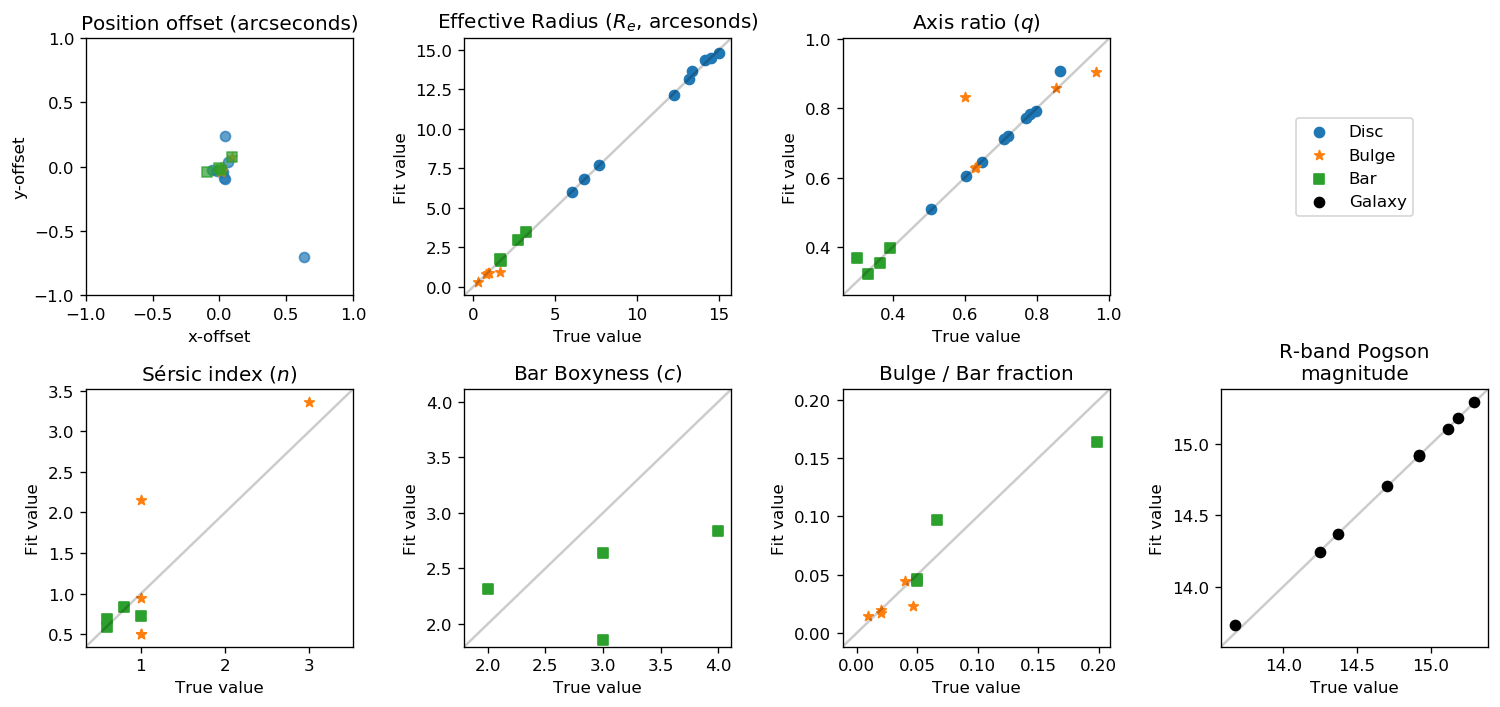

In [35]:
f, ax = plt.subplots(ncols=4, nrows=2, figsize=(4*3 + 0.6, 3*2), dpi=120)

[a.axis('off') for a in ax.ravel()];

def format_axis(ax):
    ax.axis('on')
    lims = np.stack((ax.get_xlim(), ax.get_ylim()))
    ax.add_line(plt.Line2D((-10000, 10000), (-10000, 10000), c='k', alpha=0.2))
    ax.set_xlim(lims[:, 0].min(), lims[:, 1].max())
    ax.set_ylim(lims[:, 0].min(), lims[:, 1].max())    
    ax.set_xlabel('True value')
    ax.set_ylabel('Fit value')

    
# (0,0) is position offset (x and y) (scaled?)
plt.sca(ax[0, 0])
plt.title('Position offset (arcseconds)')
plt.scatter(
    (fitting_df.loc['disk_fit', 'mux_fit'] - fitting_df.loc['disk', 'mux']) * 0.396,
    (fitting_df.loc['disk_fit', 'muy_fit'] - fitting_df.loc['disk', 'muy']) * 0.396,
    alpha=0.7
)
plt.scatter(
    (fitting_df.loc['bulge_fit', 'mux_fit'] - fitting_df.loc['bulge', 'mux']) * 0.396,
    (fitting_df.loc['bulge_fit', 'muy_fit'] - fitting_df.loc['bulge', 'muy']) * 0.396,
    c='C1', marker='*', alpha=0.7
)
plt.scatter(
    (fitting_df.loc['bar_fit', 'mux_fit'] - fitting_df.loc['bar', 'mux']) * 0.396,
    (fitting_df.loc['bar_fit', 'muy_fit'] - fitting_df.loc['bar', 'muy']) * 0.396,
    c='C2', marker='s', alpha=0.7
)
plt.axis('on')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.xlabel('x-offset')
plt.ylabel('y-offset')
# (0,1) is size
plt.sca(ax[0, 1])
plt.title(r'Effective Radius ($R_e$, arcesonds)')
plt.scatter(
    fitting_df.loc['disk', 'Re'] * 0.396,
    fitting_df.loc['disk_fit', 'Re_fit'] * 0.396,
)
plt.scatter(
    fitting_df.loc['bulge', 'Re'] * 0.396,
    fitting_df.loc['bulge_fit', 'Re_fit'] * 0.396,
    c='C1', marker='*'
)
plt.scatter(
    fitting_df.loc['bar', 'Re'] * 0.396,
    fitting_df.loc['bar_fit', 'Re_fit'] * 0.396,
    c='C2', marker='s'
)
format_axis(ax[0, 1])
# (1,2) is ellipticity
plt.sca(ax[0, 2])
plt.title(r'Axis ratio ($q$)')
plt.scatter(
    fitting_df.loc['disk', 'q'],
    fitting_df.loc['disk_fit', 'q_fit'],
)
plt.scatter(
    fitting_df.loc['bulge', 'q'],
    fitting_df.loc['bulge_fit', 'q_fit'],
    c='C1', marker='*'
)
plt.scatter(
    fitting_df.loc['bar', 'q'],
    fitting_df.loc['bar_fit', 'q_fit'],
    c='C2', marker='s'
)
format_axis(ax[0, 2])


# (1,0) is sersic index
plt.sca(ax[1, 0])
plt.title(r'Sérsic index ($n$)')
plt.scatter(
    fitting_df.loc['bulge', 'n'],
    fitting_df.loc['bulge_fit', 'n_fit'],
    c='C1', marker='*'
)
plt.scatter(
    fitting_df.loc['bar', 'n'],
    fitting_df.loc['bar_fit', 'n_fit'],
    c='C2', marker='s'
)
format_axis(ax[1, 0])

# (1,1) is bar boxyness
plt.sca(ax[1, 1])
plt.title(r'Bar Boxyness ($c$)')
plt.scatter(
    fitting_df.loc['bar', 'c'],
    fitting_df.loc['bar_fit', 'c_fit'],
    c='C2', marker='s'
)
format_axis(ax[1, 1])

# (1,2) is bulge / bar fraction
plt.sca(ax[1, 2])
plt.title('Bulge / Bar fraction')
plt.scatter(true_luminosities['bulge_frac'].reindex(recovered_luminosities.index), recovered_luminosities['bulge_frac'], c='C1', marker='*')
plt.scatter(true_luminosities['bar_frac'].reindex(recovered_luminosities.index), recovered_luminosities['bar_frac'], c='C2', marker='s')
format_axis(ax[1, 2])


# (1,3) is total luminosity
plt.sca(ax[1, 3])
plt.title('R-band Pogson\nmagnitude')

def to_mag(L):
    return 22.5 - 2.5 * np.log10(L)

plt.scatter(
    to_mag(true_luminosities['total'].reindex(recovered_luminosities.index) * multipliers),
    to_mag(recovered_luminosities['r_band_luminosity'] * multipliers),
    c='k'
)
format_axis(ax[1, 3])
# plt.xscale('log')
# plt.yscale('log')


plt.sca(ax[0, 3])
plt.scatter([], [], label='Disc')
plt.scatter([], [], c='C1', marker='*', label='Bulge')
plt.scatter([], [], c='C2', marker='s', label='Bar')
plt.scatter([], [], c='k', marker='o', label='Galaxy')
plt.legend(loc='center')

plt.tight_layout()
plt.savefig('method-paper-plots/calibration_parameter_recovery.pdf', bbox_inches='tight')
plt.savefig('method-paper-plots/calibration_parameter_recovery.png', bbox_inches='tight')

## Spiral pitch angle recovery

In [36]:
agg_pitch_angles = agg_results.apply(lambda a: pd.Series([b.pa * b.chirality for b in a.spiral_arms], dtype=float))
agg_pitch_angles.index = index_map.name[agg_pitch_angles.index]
agg_pitch_angles.columns = pd.MultiIndex.from_product([['spiral_agg'], [f'phi.{i}' for i in agg_pitch_angles.columns]])
agg_pitch_angles

spiral_agg                      
                             phi.0      phi.1      phi.2
name                                                    
disk_bar_sp_model        -9.739853  -8.938560        NaN
disk_bulge_bar_model           NaN        NaN        NaN
disk_bulge_model2              NaN        NaN        NaN
disk_sp_model           -27.971335 -25.122889 -14.887823
disk_bulge_sp_model      13.289048  13.314886        NaN
disk_model                     NaN        NaN        NaN
disk_bulge_bar_sp_model  35.317624  19.635942        NaN
disk_bar_sp_model2       25.000588  21.416780        NaN
disk_bulge_model               NaN        NaN        NaN

In [37]:
spiral_df = pd.concat((
    fitting_df.loc[[('spiral', f'phi.{i}') for i in range(3)]],
    fitting_df.loc[[('spiral_fit', f'phi.{i}_fit') for i in range(3)]],
    agg_pitch_angles.T
), axis=0)

agg_pa_err = pd.Series([], dtype=object)
fit_pa_err = pd.Series([], dtype=object)
for model in spiral_df.columns:
    base_spirals = spiral_df[model].xs('spiral').reset_index(drop=True).rename('phi_base')
    agg_spirals = spiral_df[model].xs('spiral_agg').reset_index(drop=True).rename('phi_agg')
    fit_spirals = spiral_df[model].xs('spiral_fit').reset_index(drop=True).rename('phi_fit')
    agg_idx = pd.MultiIndex.from_product([base_spirals.index, agg_spirals.index], names=['base', 'agg'])
    agg_pairs = pd.concat([
        base_spirals.reindex(agg_idx, level='base'),
        agg_spirals.reindex(agg_idx, level='agg')
    ], axis=1)
    fit_idx = pd.MultiIndex.from_product([base_spirals.index, fit_spirals.index], names=['base', 'fit'])
    fit_pairs = pd.concat([
        base_spirals.reindex(fit_idx, level='base'),
        fit_spirals.reindex(fit_idx, level='fit')
    ], axis=1)
    agg_pa_err.loc[model] = (agg_pairs.phi_base - agg_pairs.phi_agg).abs().dropna().min(level=0)    
    fit_pa_err.loc[model] = (fit_pairs.phi_base - fit_pairs.phi_fit).abs().dropna().min(level=0)

In [38]:
display(agg_pa_err.apply(pd.Series).T.unstack().dropna().sort_values().rename('aggregate'))
display(fit_pa_err.apply(pd.Series).T.unstack().dropna().sort_values().rename('fit'))

                         base
disk_bar_sp_model        1       0.104838
disk_bulge_bar_sp_model  0       0.364058
disk_bar_sp_model2       0       1.416780
disk_bulge_bar_sp_model  1       1.483434
disk_sp_model            0       3.619919
disk_bar_sp_model2       1       3.801189
disk_sp_model            2       3.857301
                         1       5.073800
disk_bar_sp_model        0       7.315314
disk_bulge_bar_sp_model  2       7.945849
disk_bulge_sp_model      0       8.851319
                         1       8.948664
Name: aggregate, dtype: float64

                         base
disk_bulge_sp_model      0       0.032117
disk_sp_model            1       0.043185
disk_bulge_sp_model      1       0.065228
disk_sp_model            2       0.173114
disk_bar_sp_model2       0       0.183279
                         1       0.209249
disk_bar_sp_model        1       0.310947
disk_sp_model            0       0.359860
disk_bar_sp_model        0       0.404195
disk_bulge_bar_sp_model  2       2.909767
                         1       5.316293
                         0       5.400141
Name: fit, dtype: float64